In [1]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import matplotlib as mpl 
import matplotlib.pyplot as plt
import imageio

%matplotlib inline

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(5, 10))
mpl.rc('image', cmap='gray')
import numpy as np
import pandas as pd
import trackpy as tp

from pandas import DataFrame, Series  # for convenience
import os
from ntpath import basename

import pims
import pySPM as spm 
import glob

#@pims.pipeline
#def gray(image):
#    return image[:, :, 1]  # Take just the green channel
#frames = gray(pims.open('../track_molecules/*.bmp'))

class SXMReader(pims.FramesSequence):
    def __init__(self, filename_pattern):
        #self.filenames = glob.glob(filename_pattern)
        self.filenames = filename_pattern
        self.scans = [spm.SXM(filename) for filename in self.filenames]
        self.z_data = np.array([s.get_channel("Z").correct_lines().pixels for s in self.scans]) #grab z-channel
        min_z = np.min(self.z_data)
        max_z = np.max(self.z_data)
        self.z_data -= min_z
        self.z_data /= max_z-min_z
        self._len = len(self.z_data)
        self._dtype = self.z_data.dtype
        self._frame_shape = self.z_data[0].shape
        self.scan_size = self.scans[0].size
        self.meters_per_pixel = self.scan_size['real']['x']/self.scan_size['pixels']['x']
       
    def get_frame(self, i):
        # Access the data you need and get it into a numpy array.
        # Then return a Frame like so:
        return pims.Frame(self.z_data[i], frame_no=i)

    def __len__(self):
        return self._len

    @property
    def frame_shape(self):
        return self._frame_shape

    @property
    def pixel_type(self):
        return self._dtype

if False:
    frames = SXMReader("figure1/*.sxm")
    molecule_size = 9
    min_mass = 2.0
    min_size = 1.5
    max_ecc = 0.3
    
if True:
    n_range = range(40,90)
    N = len(n_range)
    SXM_PATH = ["electromigration_29/Image_{0:03}.sxm".format(i) for i in n_range]
    frames = SXMReader(SXM_PATH)
    molecule_size = 9
    min_mass = 2.0
    max_mass = 2.75
    min_size = 1.5
    max_ecc = 0.3

In [2]:
"""
f = tp.locate(frames[7], molecule_size, minmass=1)
tp.annotate(f, frames[7])

fig, ax = plt.subplots()
ax.hist(f['mass'], bins=20)

# Optionally, label the axes.
ax.set(xlabel='mass', ylabel='count');
"""

f = tp.batch(frames[:], molecule_size, minmass=1)
#tp.quiet()  # Turn off progress reports for best performance

Frame 49: 10 features


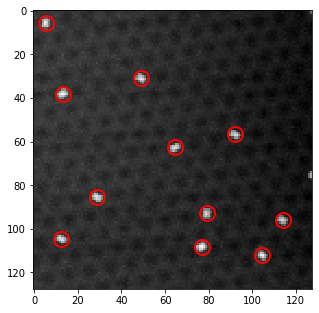

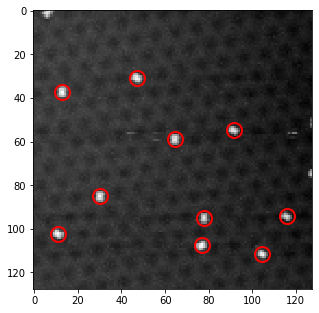

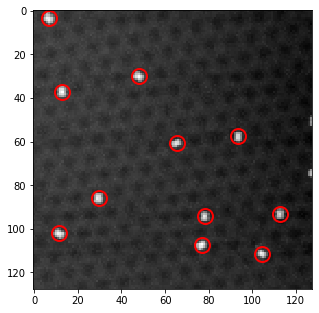

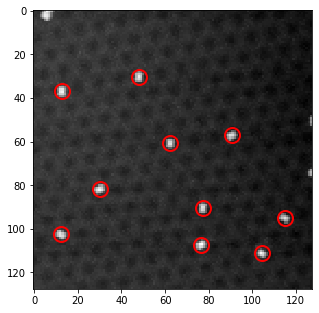

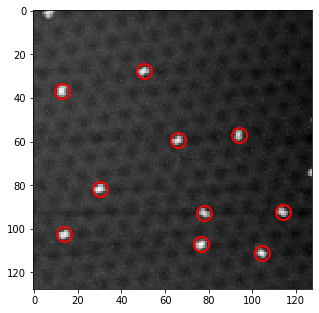

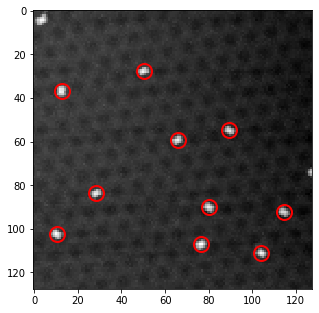

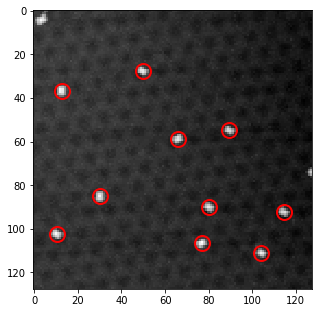

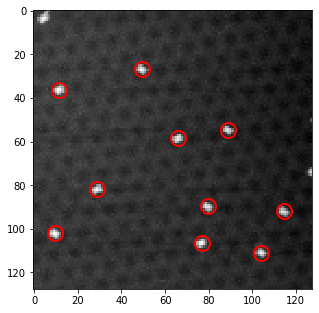

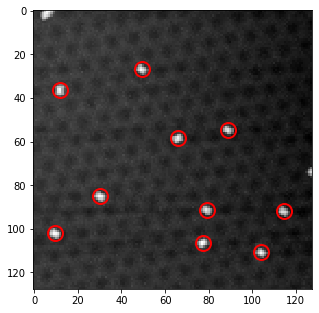

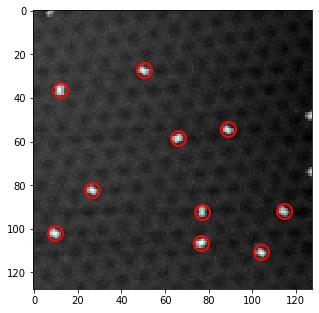

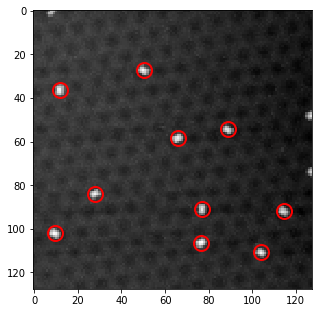

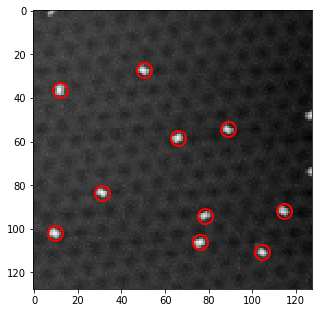

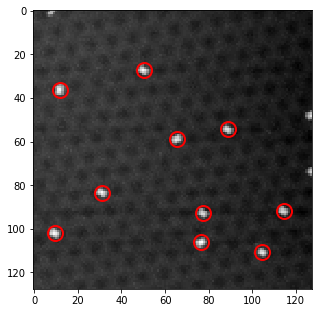

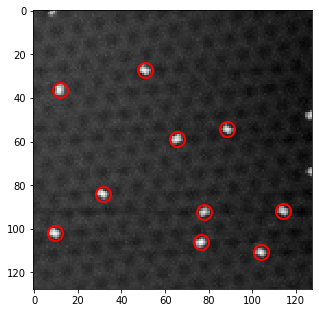

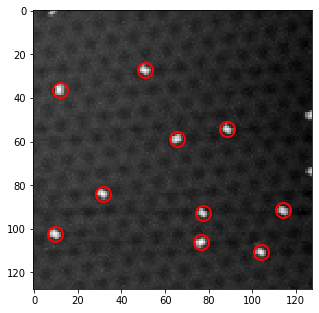

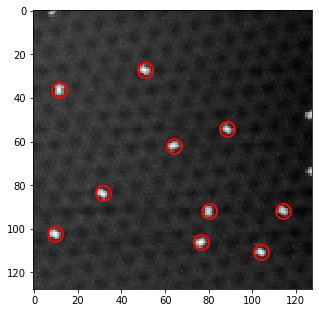

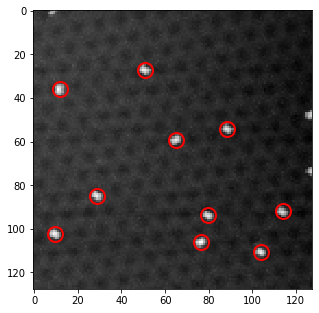

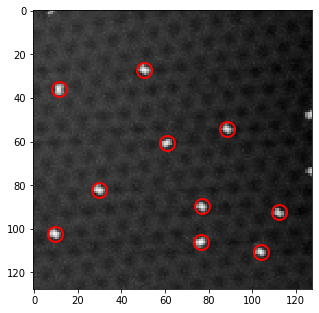

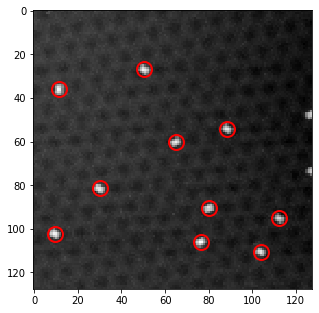

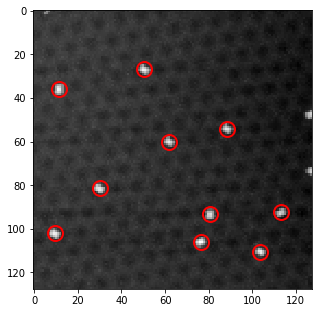

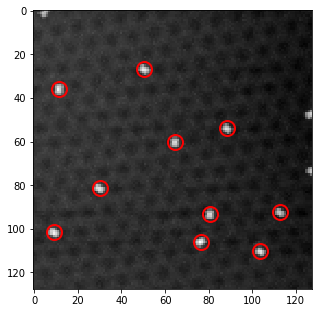

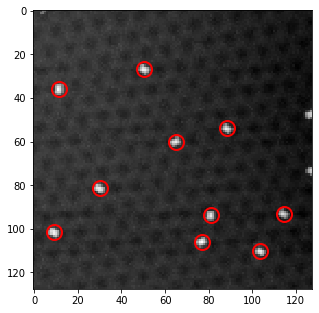

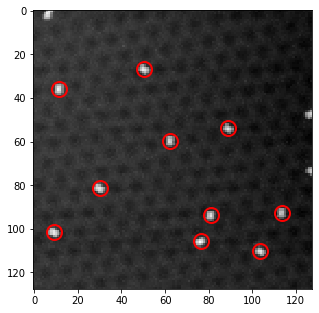

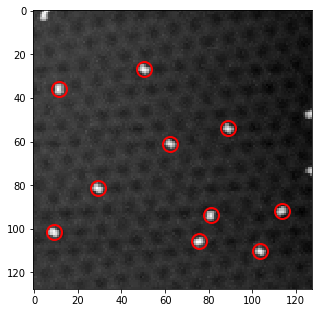

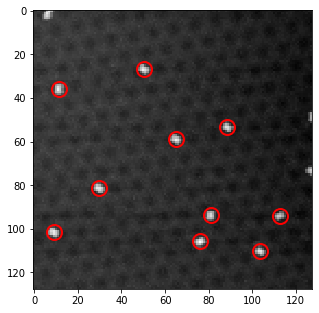

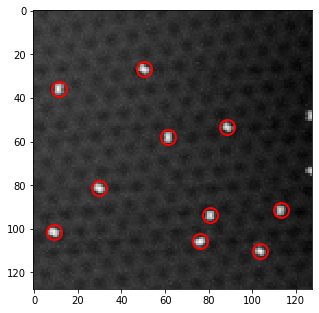

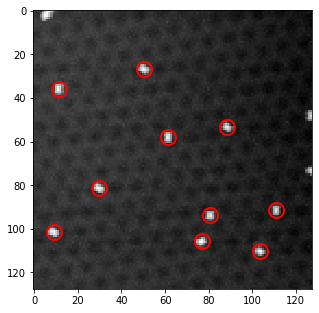

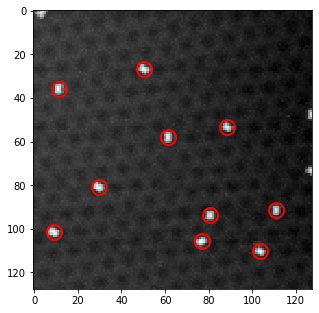

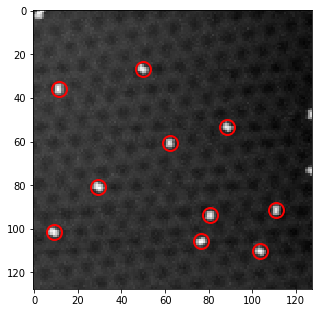

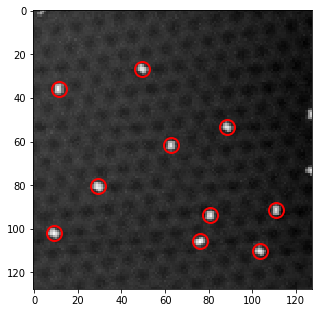

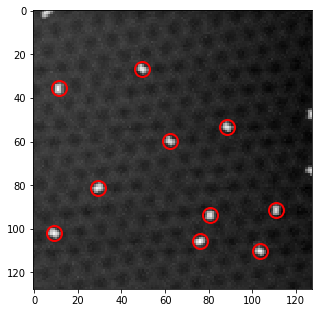

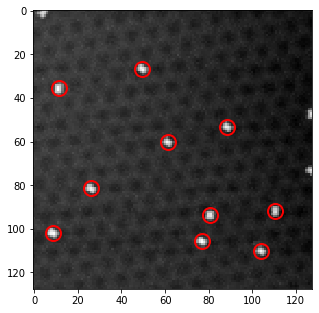

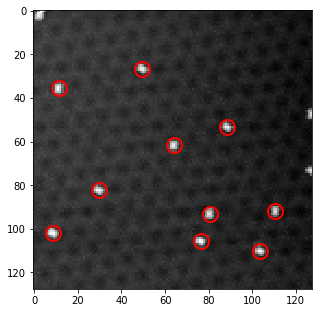

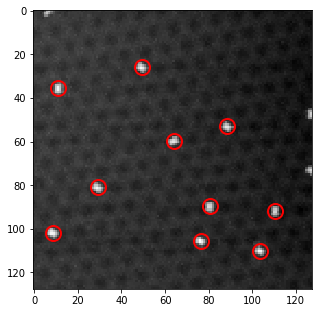

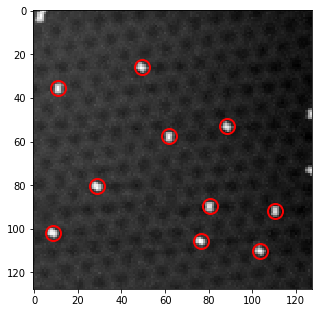

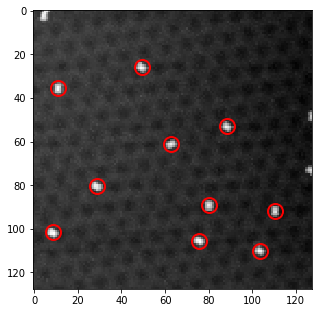

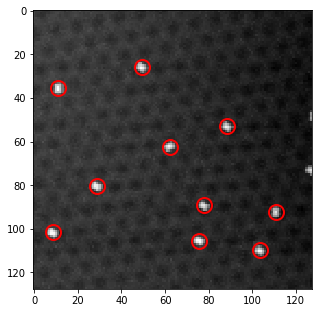

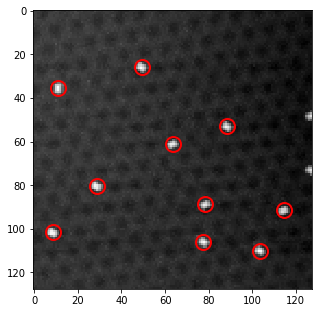

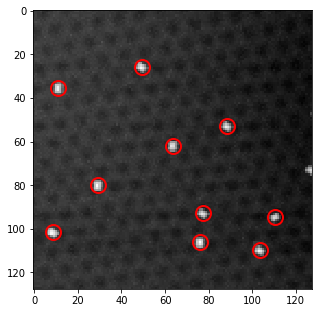

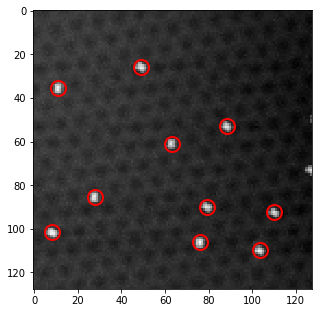

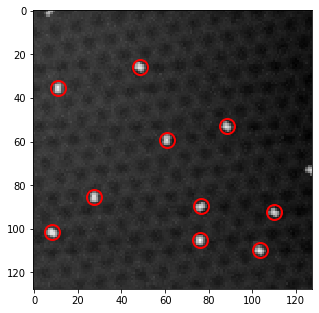

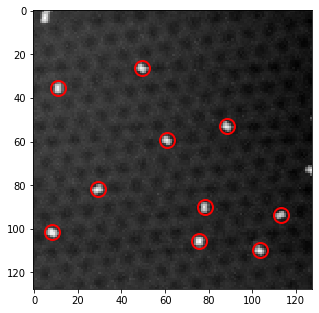

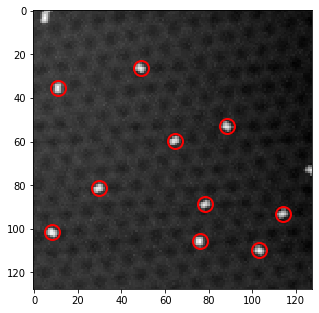

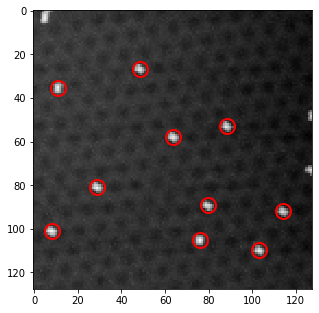

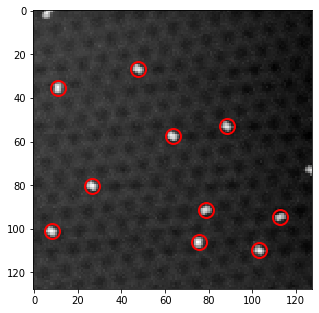

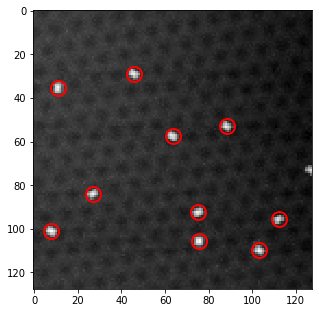

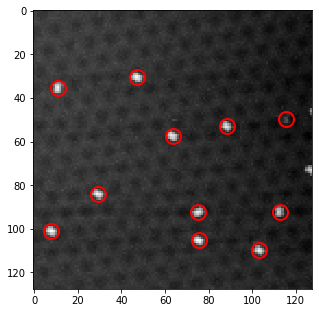

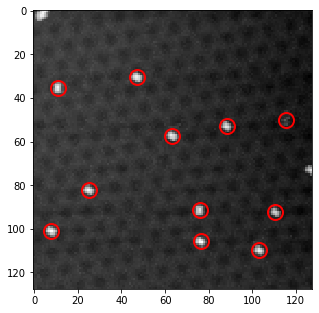

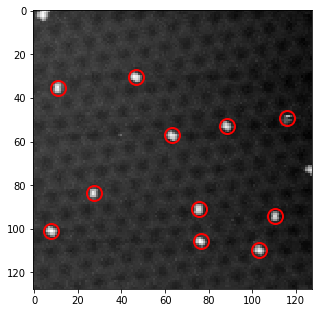

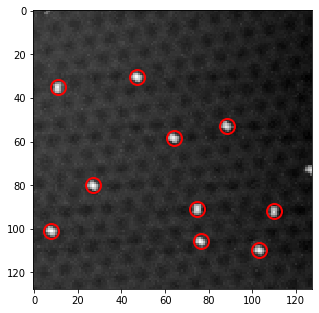

In [3]:
plt.figure()

for i,frame in enumerate(frames):
    tp.annotate(f[f['frame']==i], frame)

Frame 16: 12 trajectories present.


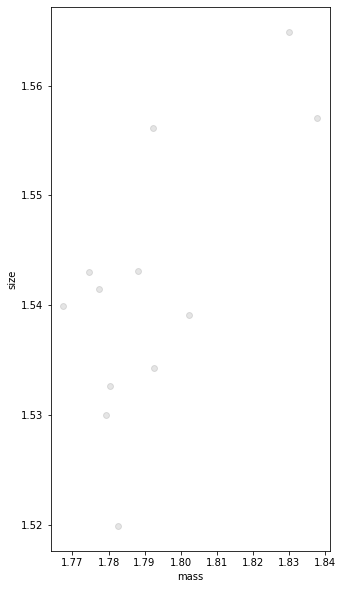

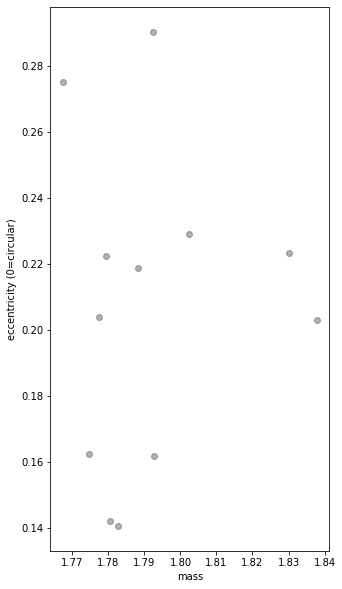

In [396]:
t = tp.link(f, search_range=70, adaptive_stop=5, memory=3)
plt.figure()
tp.mass_size(t.groupby('particle').mean()); # convenience function -- just plots size vs. mass
tp.mass_ecc(t.groupby('particle').mean()); # convenience function -- just plots size vs. mass

In [397]:
t1 = t[((t['mass'] > min_mass) & (t['size'] > min_size) &
         (t['ecc'] < max_ecc)) & (t['mass'] < max_mass)]
t2 = tp.filter_stubs(t, 1)

# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t2['particle'].nunique())

Before: 12
After: 12


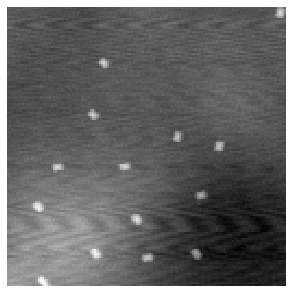

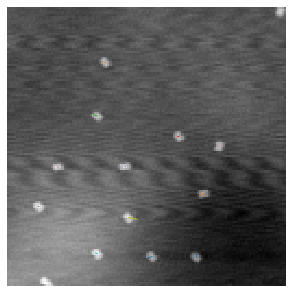

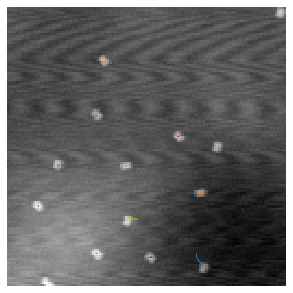

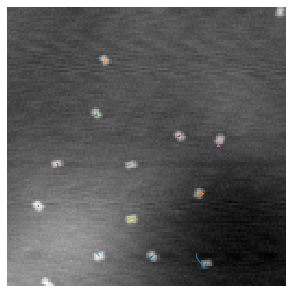

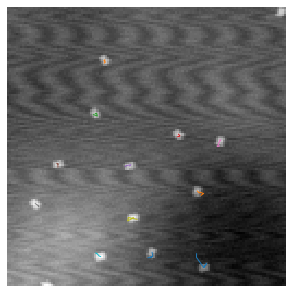

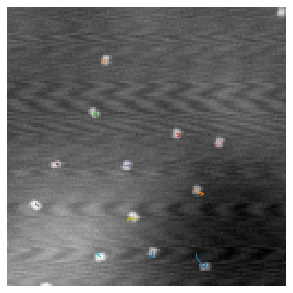

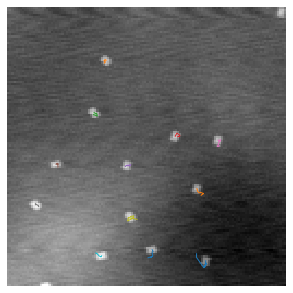

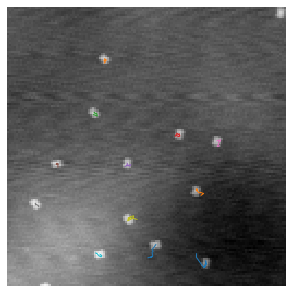

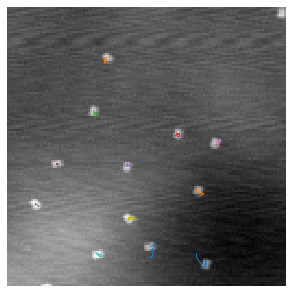

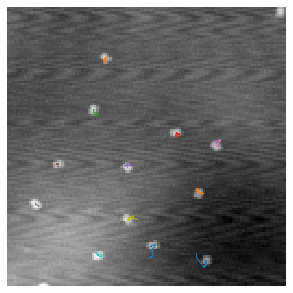

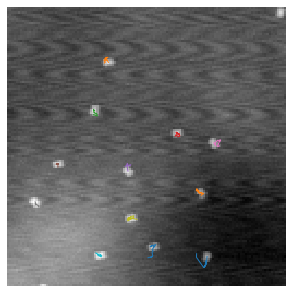

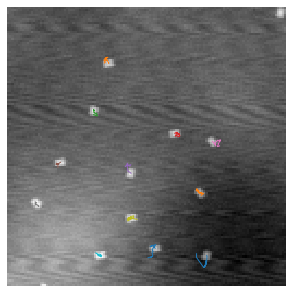

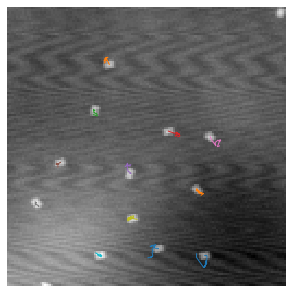

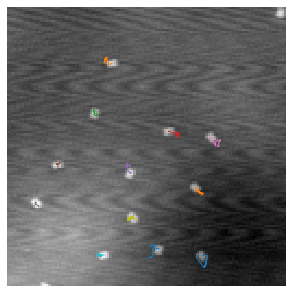

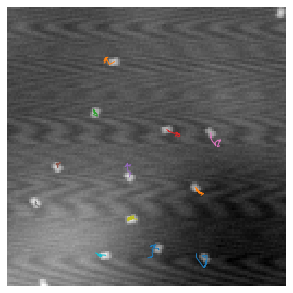

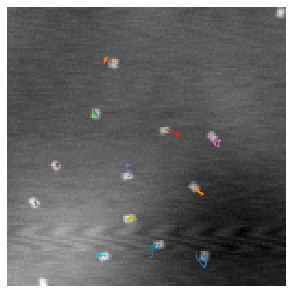

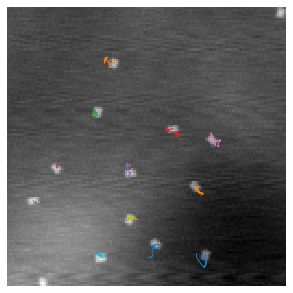

In [399]:
for i,frame in enumerate(frames):
    fig=plt.figure()
    ax1=plt.axes(frameon=False)
    tp.plot_traj(t2[t2['frame']<=i], superimpose=frame, ax=ax1);
    plt.axis('off')
    plt.gca().invert_yaxis()
    #fig.savefig('electromigration_movie/tracking_9/'+'{0:03}'.format(i)+'.png', bbox_inches='tight')

In [400]:
d = tp.compute_drift(t2)
t3 = tp.subtract_drift(t2.copy(), d)
#t3 = t2
print(d)

              y         x
frame                    
1      0.023934  0.228367
2     -0.230664  0.164890
3      0.406928  0.828372
4      0.481791  0.584624
5      0.684071  0.390597
6      0.928508  0.143896
7      1.219600  0.252502
8      1.085536  0.044370
9      0.984867  0.086772
10     0.939273  0.547528
11     0.906177  0.647527
12     1.192850  0.325711
13     1.071186  0.347881
14     1.104919  0.453206
15     1.143934  0.049273
16     1.203680  0.409375


(-4, 4)

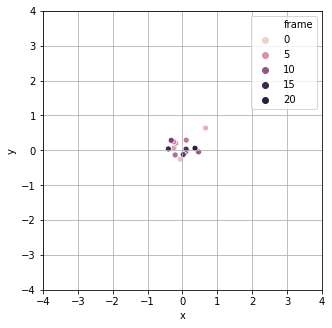

In [401]:
fig, ax = plt.subplots();
sns.scatterplot(x='x', y='y', hue='frame', data=d.diff().reset_index())
ax.set_aspect('equal')
ax.grid('on')
ax.set_xlim([-4,4])
ax.set_ylim([-4,4])

bad: []


ValueError: DataFrame of trajectories is empty.

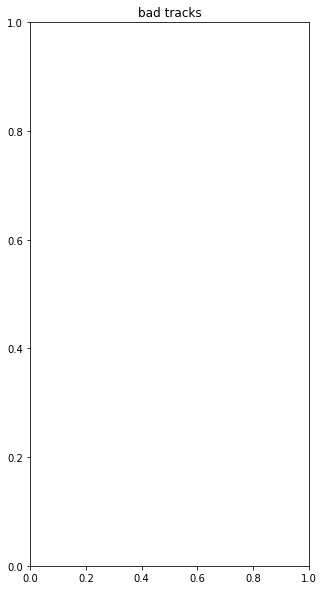

In [410]:
good_particles = []
bad_particles = []
t4 = t3.groupby('particle').filter(lambda x: len(x) >= 2)
paths = []
def is_track_good(track):
    global displacements
    x = track['x'].values
    y = track['y'].values
    denan = lambda x: x[~np.isnan(x)]
    x = denan(x) 
    y = denan(y) 
    pos = np.array([x,y]).T
    delta = pos[1:]-pos[:-1]
    mean_square = np.einsum("ij, ij->i", delta, delta)
    good = np.max(mean_square) < (1e-8/frames.meters_per_pixel)**2
    (good_particles if good else bad_particles).append(track['particle'].values[0])
    if(good):
        paths.append(delta)
    return good 
#movement_filter = t4.groupby('particle').apply(is_track_good).values
tm = t4.groupby('particle').filter(is_track_good)
print("bad:", bad_particles)
plt.figure()
plt.title("bad tracks")
tp.plot_traj(t4.groupby('particle').filter(lambda x: not is_track_good(x)), mpp=(frames.meters_per_pixel*1e6), superimpose=frames[0]);
print("good:", good_particles)
plt.title("good tracks")
tp.plot_traj(tm, mpp=(frames.meters_per_pixel*1e6), superimpose=frames[0]);
im = tp.imsd(tm, 1e6*frames.meters_per_pixel, 1)  # microns per pixel = 100/285., frames per second = 24
#im = im.T[movement_filter].T 
print(im)

The mean square displacement is:  0.23734563062386008 nm


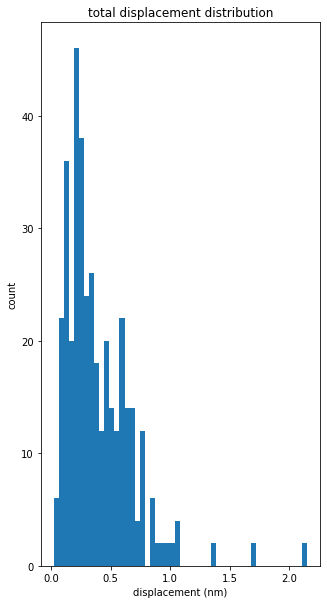

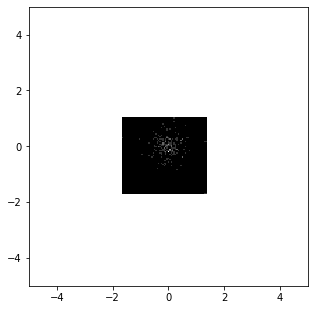

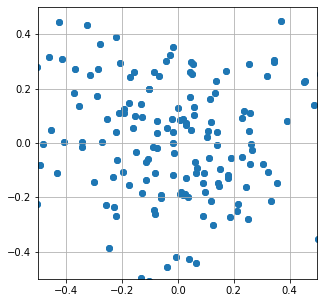

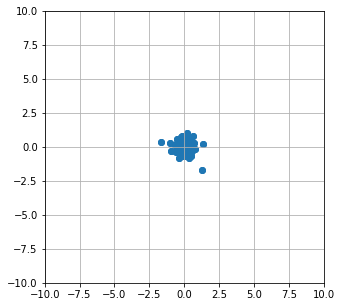

In [411]:
displacements = np.concatenate(paths)*frames.meters_per_pixel*1e9
dists = np.sqrt(np.einsum("ij, ij->i", displacements, displacements))
print("The mean square displacement is: ", (dists**2).mean(), "nm")
plt.title("total displacement distribution")
plt.xlabel("displacement (nm)")
plt.ylabel("count")
plt.hist(dists, bins=50);
fig, ax = plt.subplots()
ax.set_aspect('equal', 'box')
ax.hist2d(displacements.T[0], displacements.T[1], bins = 60, cmax=50);
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.figure(figsize=(5,5));
import seaborn as sns
displacement_df = pd.DataFrame(displacements, columns=['dx','dy'])
#g = sns.jointplot(x="dx", y="dy", data=displacement_df)
plt.scatter(displacement_df['dx'],displacement_df['dy'])
plt.xlim(-0.5,0.5)
plt.ylim(-0.5,0.5)
plt.grid()
ax.set_aspect('equal', 'box')
plt.figure(figsize=(5,5));
plt.scatter(displacement_df['dx'],displacement_df['dy'])
plt.xlim(-10,10)
plt.ylim(-10,10)
plt.grid()
ax.set_aspect('equal', 'box')

[Text(0, 0.5, '$\\langle \\Delta r^2 \\rangle$ [nm$^2$]'),
 Text(0.5, 0, 'lag time $t$')]

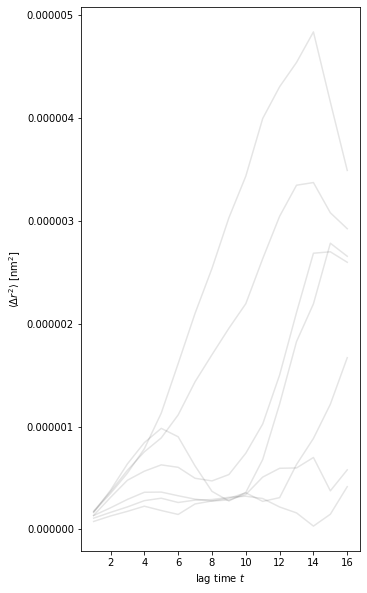

In [413]:
fig, ax = plt.subplots()
ax.plot(im.index, im, 'k-', alpha=0.1)  # black lines, semitransparent
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [nm$^2$]',
       xlabel='lag time $t$')
#ax.set_xscale('log')
#ax.set_yscale('log')

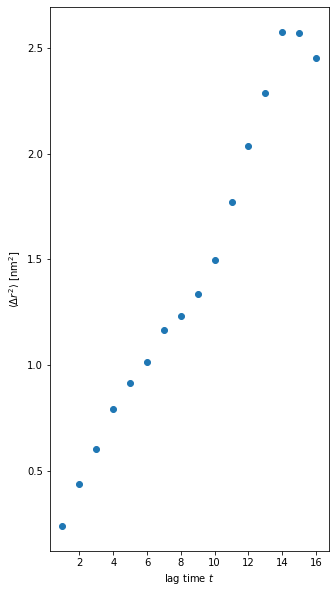

In [405]:
em = tp.emsd(tm, frames.meters_per_pixel*1e9, 1) # microns per pixel = 100/285., frames per second = 24
fig, ax = plt.subplots()
ax.plot(em.index, em, 'o')
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [nm$^2$]',
       xlabel='lag time $t$')
#ax.set(ylim=(1e-2, 10));
fig.savefig('diffusion.png')

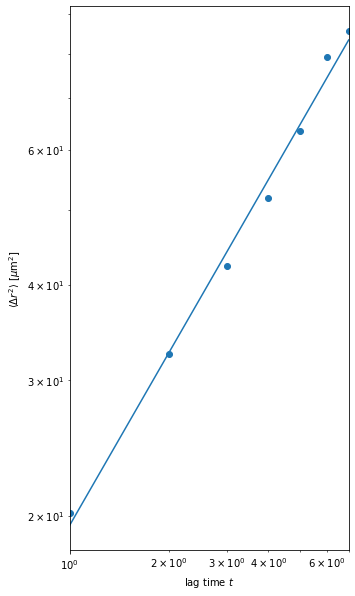

,n,A
msd,0.748484,19.425979


In [384]:
fig=plt.figure()
plt.ylabel(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]')
plt.xlabel('lag time $t$');
tp.utils.fit_powerlaw(em[:20])  # performs linear best fit in log space, plots]

/home/a/as/asai/dsgo/venv/lib/python3.7/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/home/a/as/asai/dsgo/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


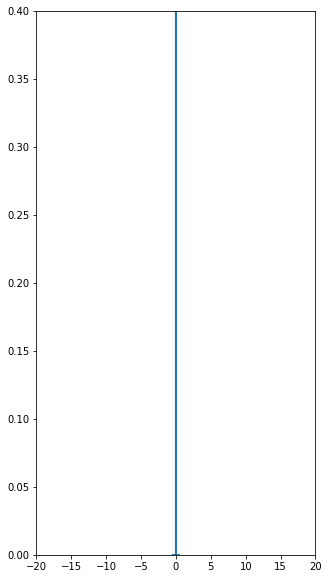

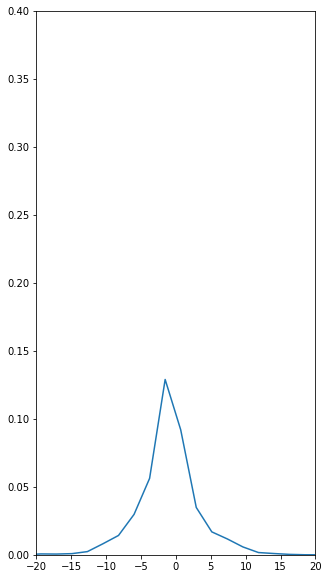

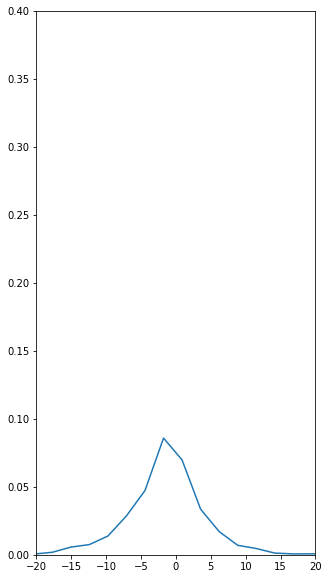

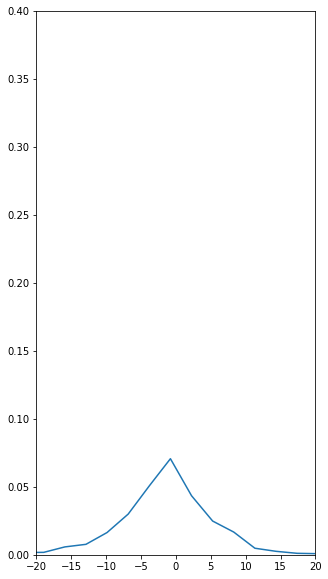

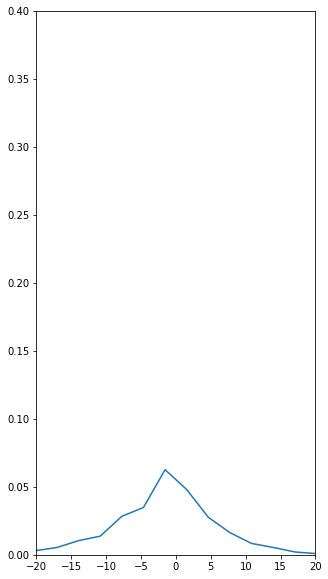

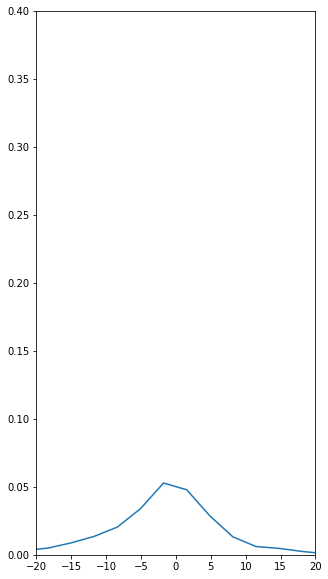

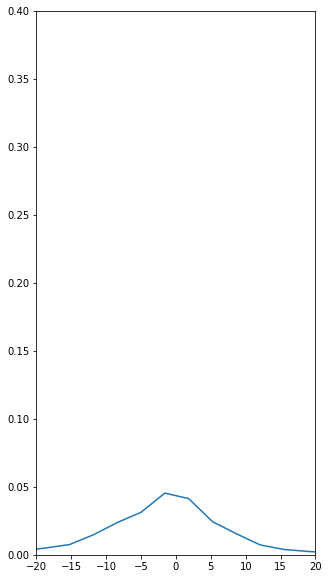

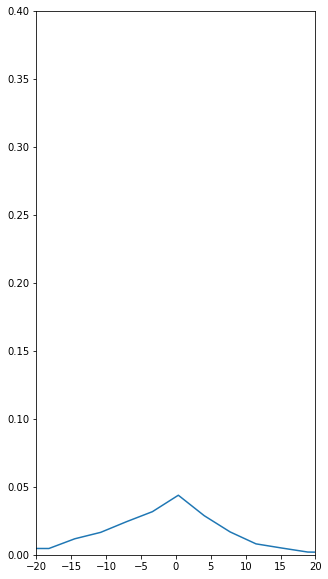

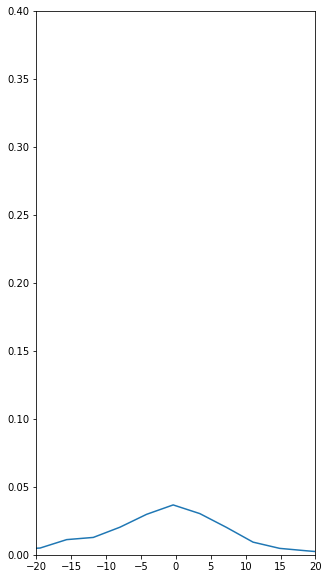

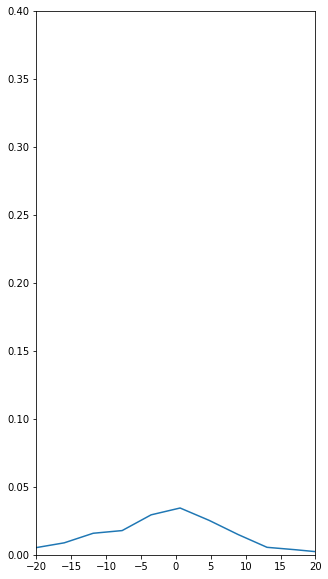

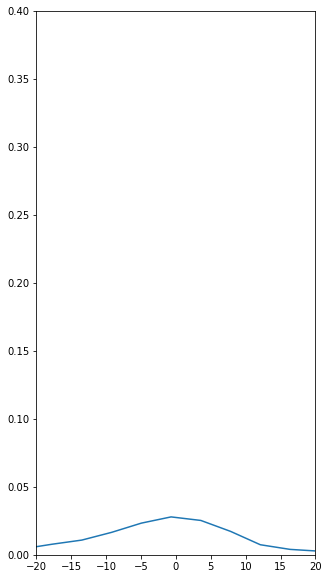

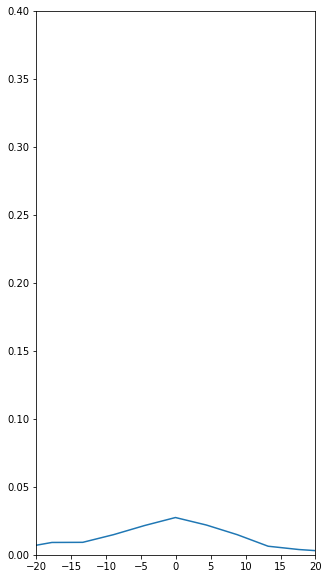

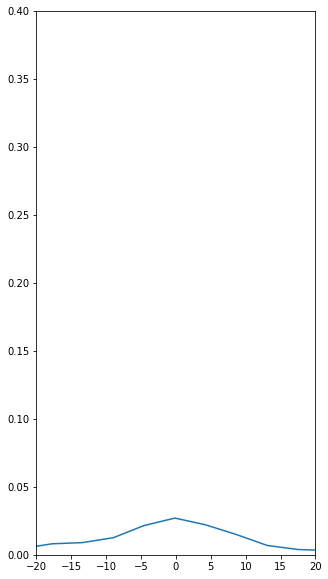

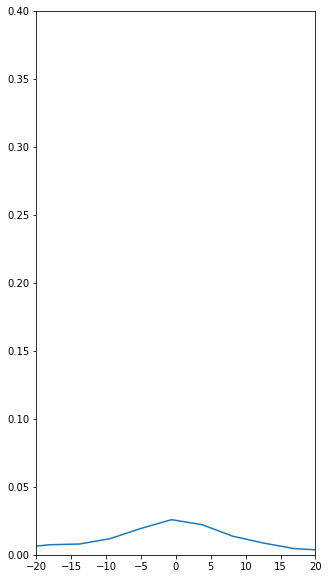

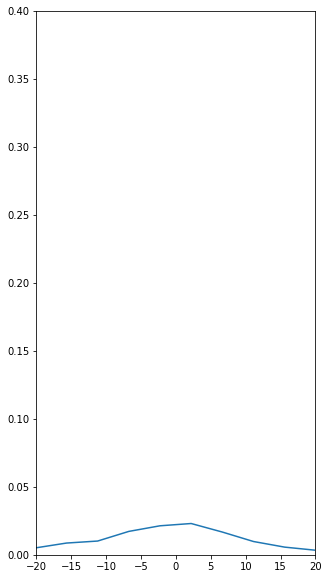

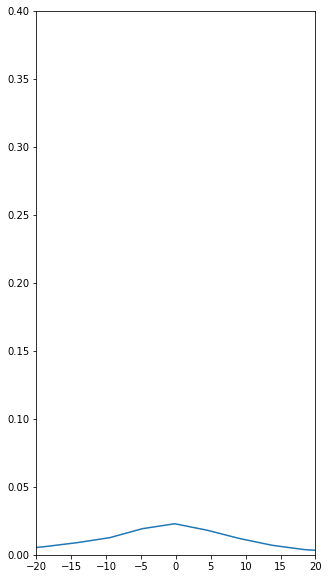

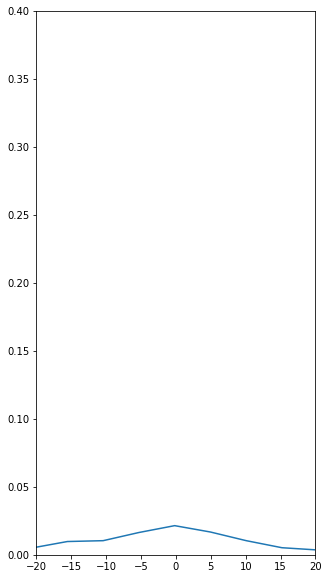

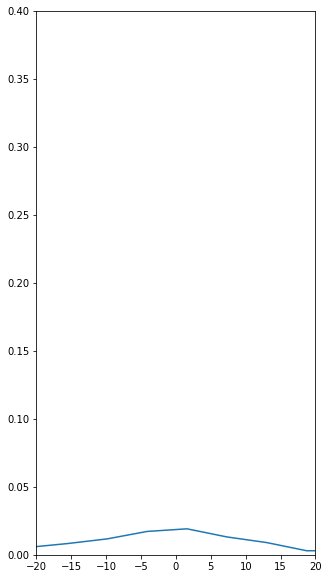

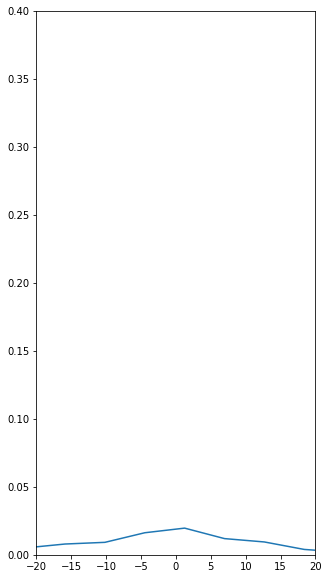

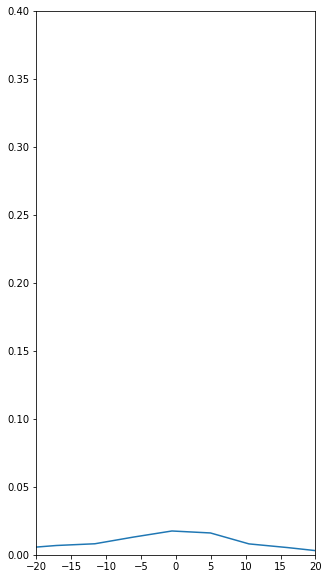

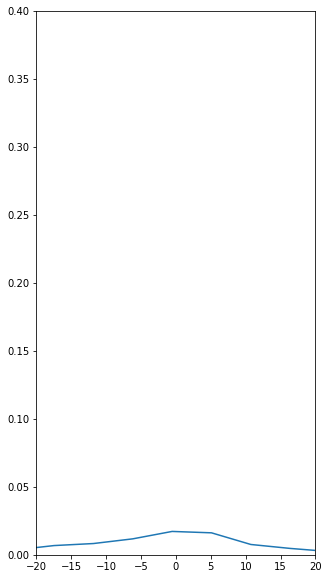

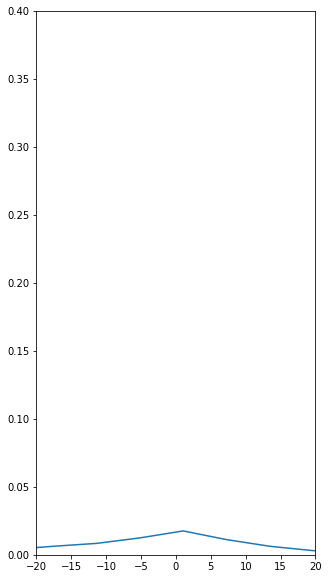

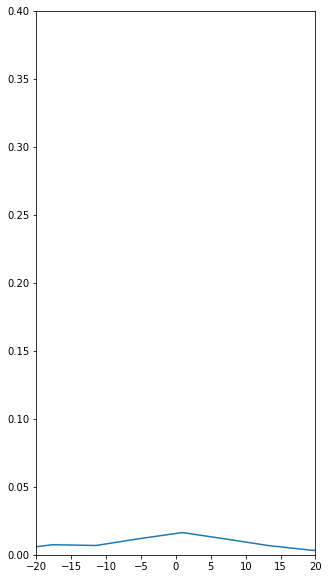

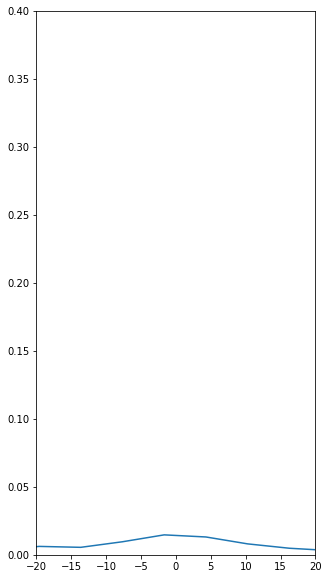

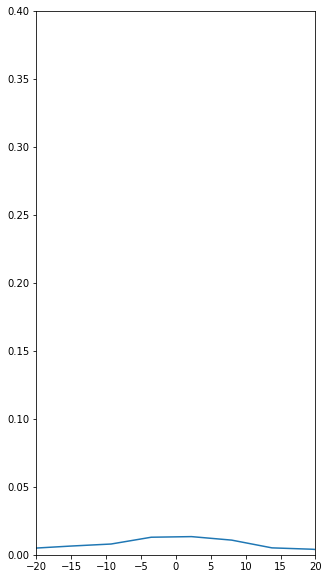

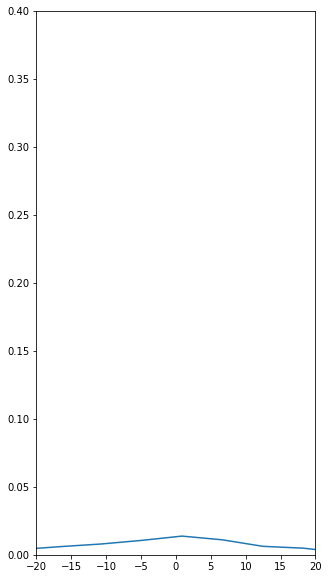

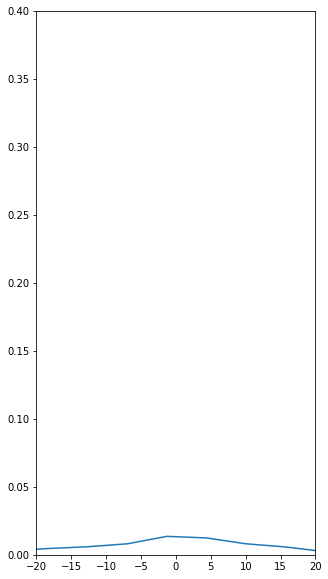

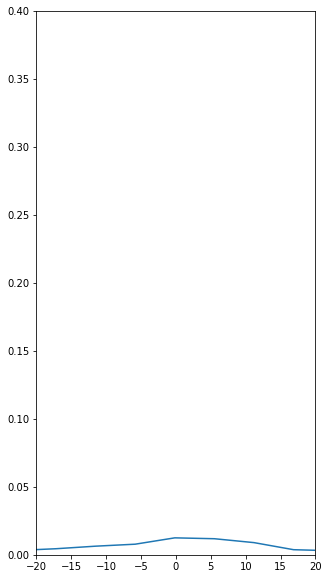

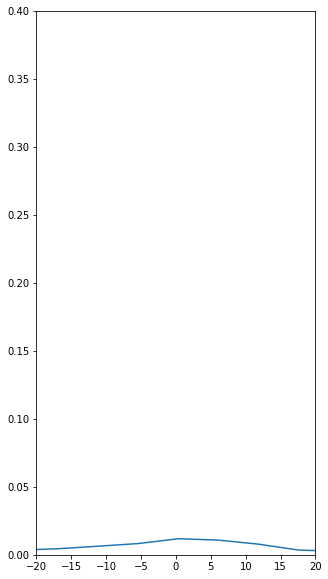

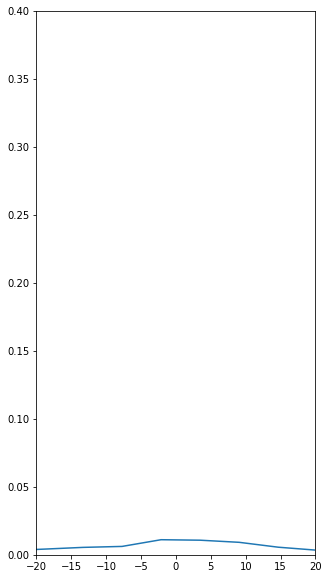

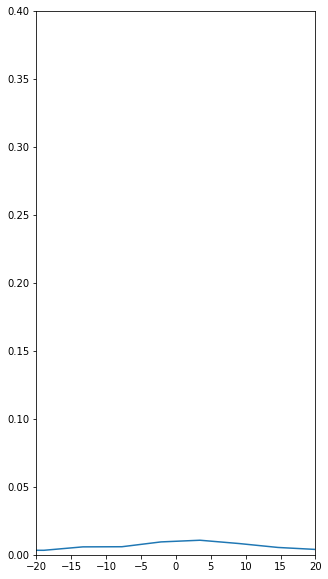

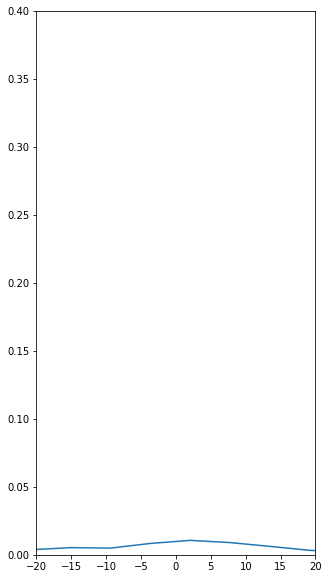

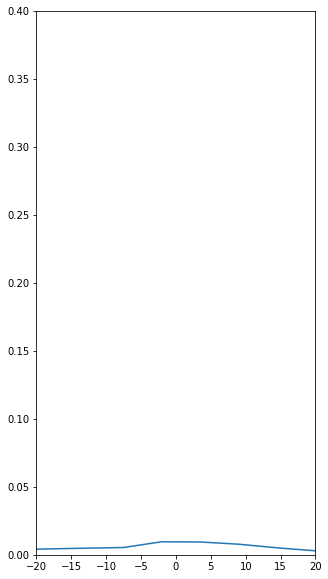

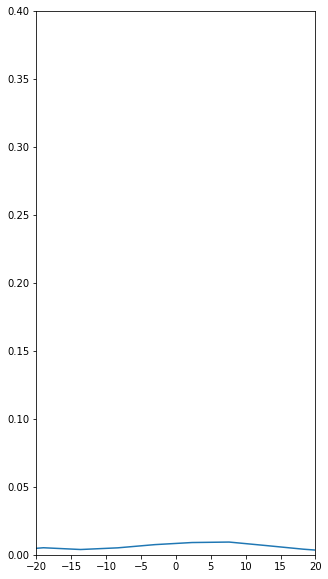

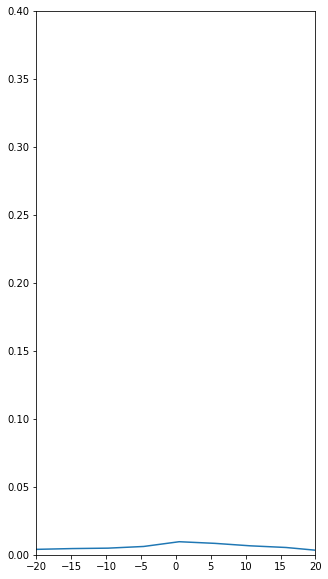

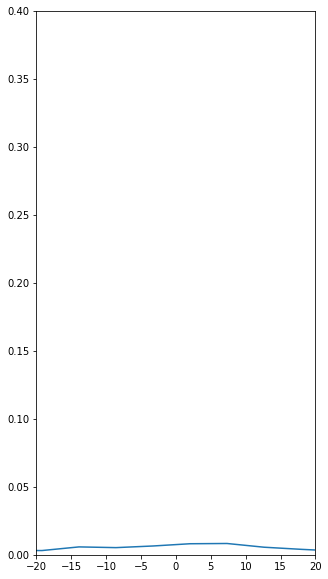

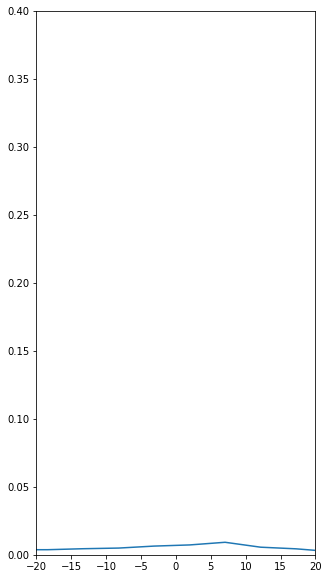

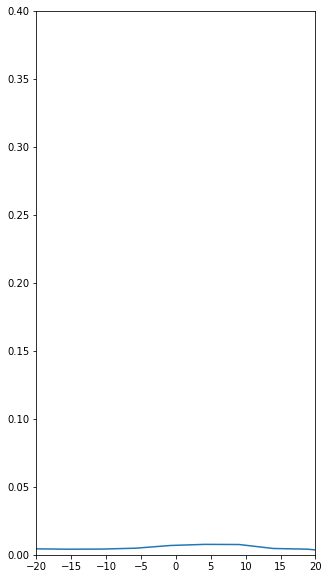

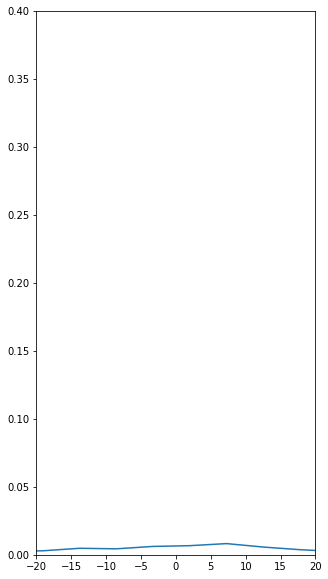

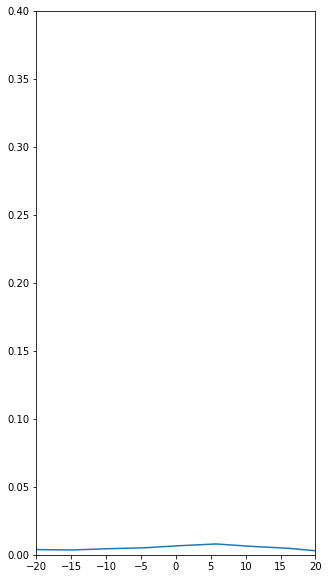

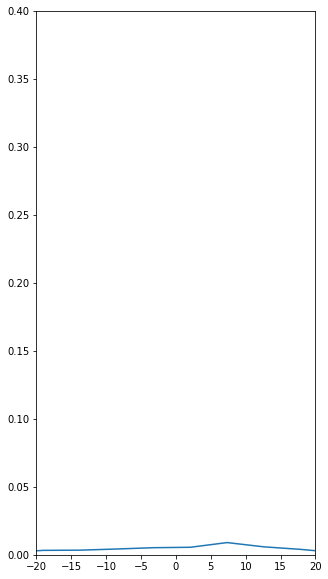

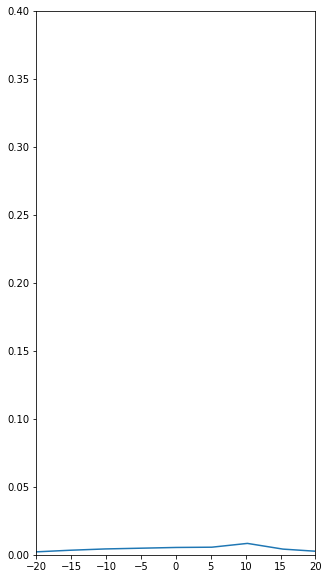

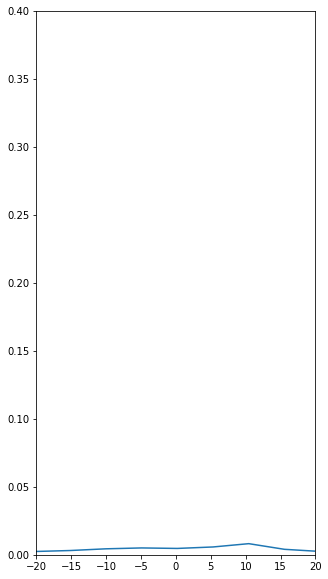

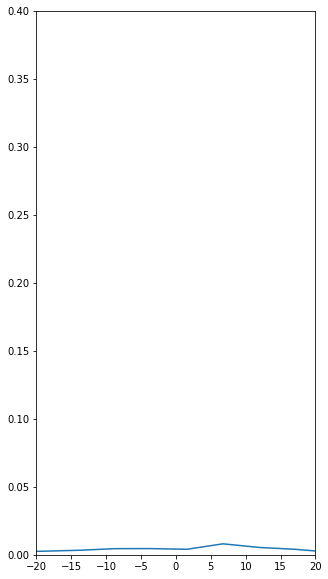

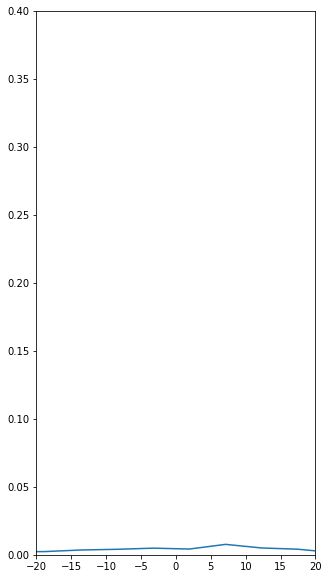

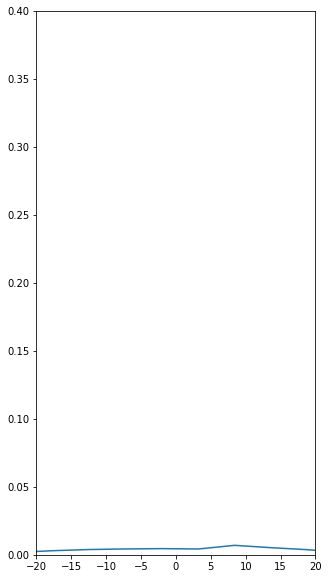

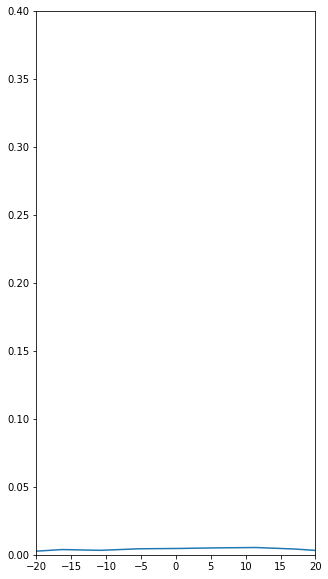

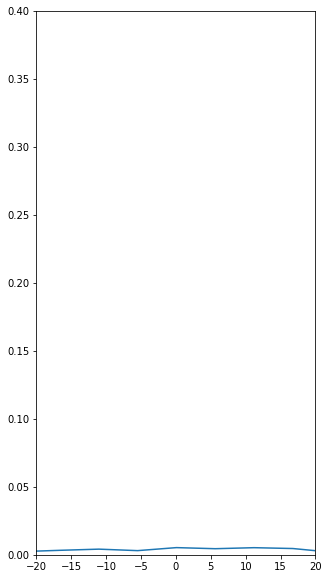

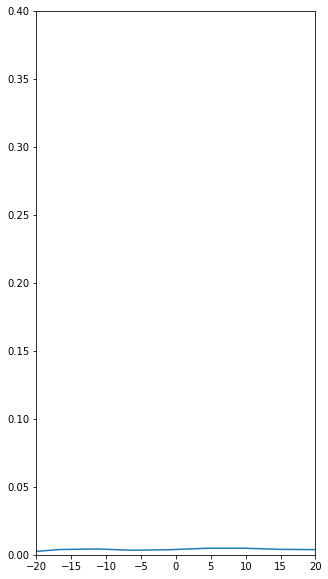

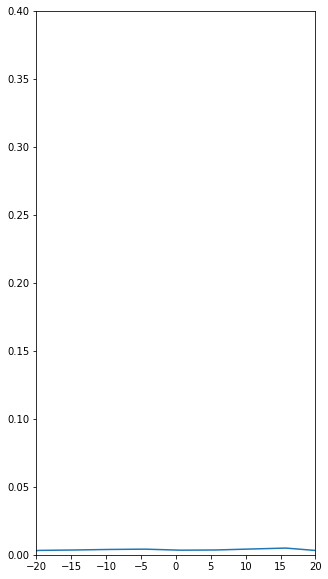

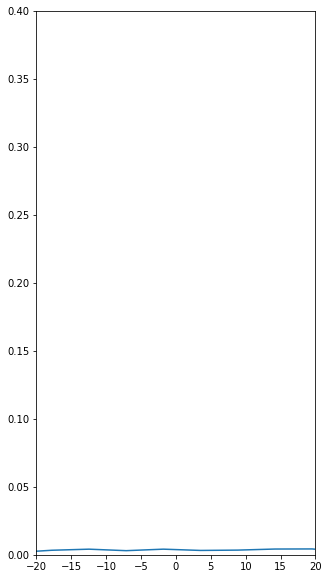

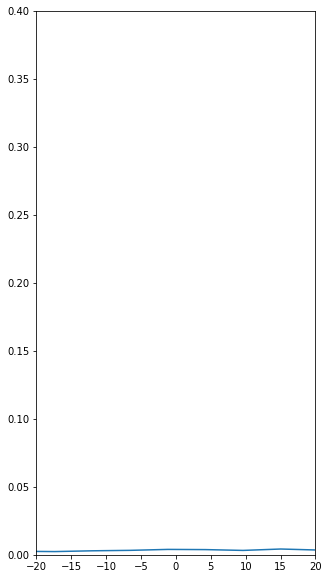

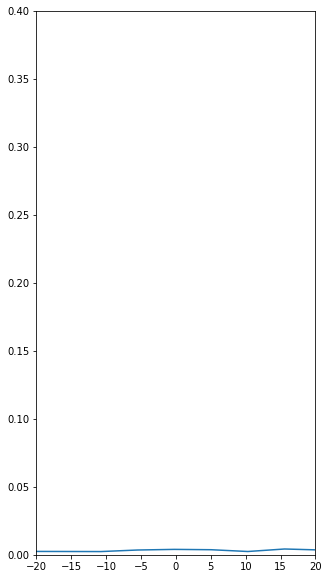

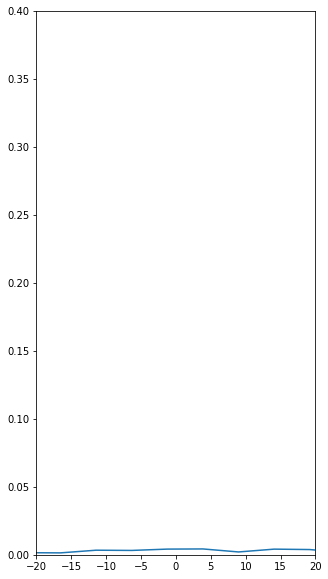

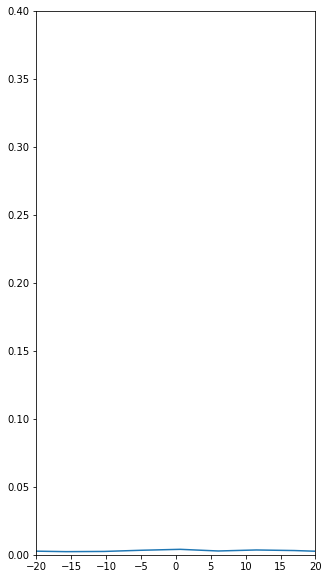

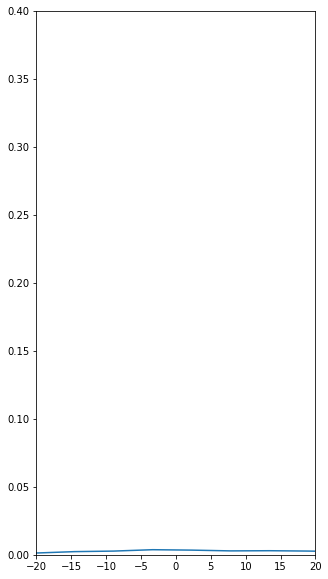

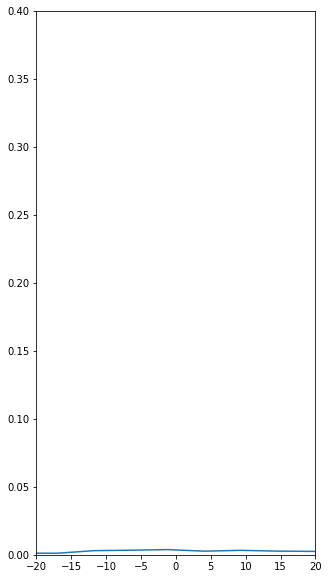

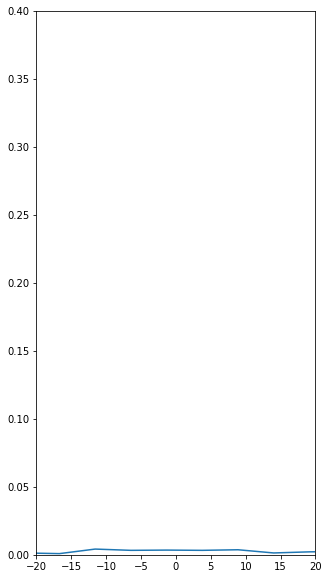

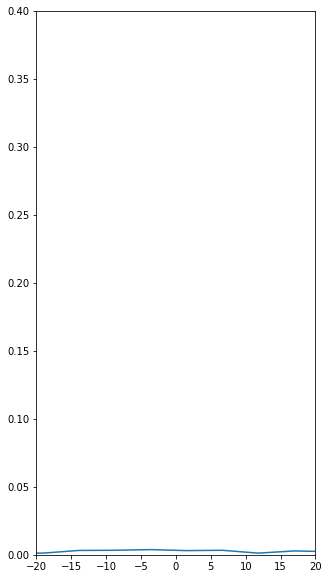

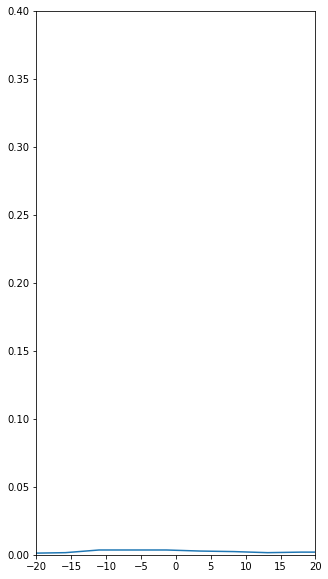

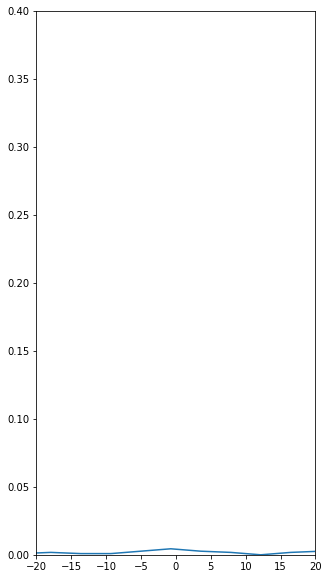

In [267]:
for i,frame in enumerate(frames):
    fig=plt.figure()
    #ax1=plt.axes(frameon=False)
    pos = t3.set_index(['frame', 'particle'])['x'].unstack()
    vh=tp.motion.vanhove(pos,i,ensemble=True)
    plt.plot(vh)
    plt.xlim(-20, 20)
    plt.ylim(0,0.4)
    #plt.axis('off')
    #fig.savefig('vanHove_'+'{0:03}'.format(i)+'.png', bbox_inches='tight')


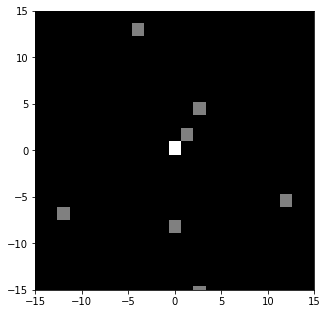

In [338]:
endpoints = [];
endpoint_vectors=[];
for path in paths:
    endpoints.append(np.array([path[0,:], path[-1,:]]))
    endpoint_vectors.append(np.array(path[-1,:]-path[0,:]))
endpoint_vectors = np.array(endpoint_vectors)
fig, ax = plt.subplots()
ax.set_aspect('equal', 'box')
#plt.scatter(endpoint_vectors[:,0],endpoint_vectors[:,1])
ax.hist2d(endpoint_vectors[:,0], endpoint_vectors[:,1], bins = 30, cmax=50);
ax.set_xlim([-15,15]);
ax.set_ylim([-15,15]);